Импортируем всякое

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import roc_auc_score

Вдруг придётся преоткрыть

In [3]:
train = None
test = None
def reload_data():
    return (pd.read_csv("../data/raw/application_train.csv"), pd.read_csv("../data/raw/application_test.csv"))

Избавимся от y\n во флагах

In [4]:
def flag_to_int(df):
    for i in df:
        if "FLAG" in i:
            df[i] = np.where((df[i] == 'Y') | (df[i] == 'y') | (df[i] == 1), 1, 0)

In [5]:
train, test = reload_data()

In [6]:
flag_to_int(train)
flag_to_int(test)

In [23]:
target = "TARGET"

Достаём часть данных, чтобы ускорить работу

In [7]:
def eq_df(df):
    positive = df[df[target] == 1]
    negative = df[df[target] == 0]

    indexes1 = np.random.choice(len(positive), replace=False, size=20000)
    indexes2 = np.random.choice(len(negative), replace=False, size=20000)


    newdf = pd.concat([positive.iloc[indexes1], negative.iloc[indexes2]]).join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b').join(pd.read_csv("../data/raw/credit_card_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_ccb').join(pd.read_csv("../data/raw/previous_application.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pa').join(pd.read_csv("../data/raw/POS_CASH_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pcb')
    return newdf
lite = eq_df(train)
flag_to_int(lite)

In [15]:
def join_(df):
    return df.join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b').join(pd.read_csv("../data/raw/credit_card_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_ccb').join(pd.read_csv("../data/raw/previous_application.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pa').join(pd.read_csv("../data/raw/POS_CASH_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pcb')
    

Функция для тестиования и измерения orc auc

In [1]:
def comp_roc(df, features, target = "TARGET"):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    
    roc_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):
        train_part = df.iloc[train_index, : ]
        train_x = train_part[features]
        train_y = train_part[target]
        
        val_part = df.iloc[val_index, :]
        test_x = val_part[features]
        test_y = val_part[target]
        
        model = LogisticRegression()
        
        model.fit(train_x, train_y)
        
        y_score = model.predict_proba(test_x)[:,1]

        roc_auc = roc_auc_score(test_y, y_score)

        print(f'Fold full {i}: roc_auc {roc_auc}, count values {y_score}')
        roc_list.append(roc_auc)

        
    print(f'roc average = {np.mean(roc_list)}, std = {np.std(roc_list)}')

Функция для тестирования и подсчёта msle

In [7]:

def comp_mse(df, features, target):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    
    msle_list = []
    mse_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):    
        train_part = df.iloc[train_index, : ]
        val_part = df.iloc[val_index, :]
        model = SGDRegressor()
        model.fit(X=train_part[features].fillna(0), y = train_part[target])
        val_predication = model.predict(val_part[features].fillna(0)).clip(0, 100000000000)

        mse = mean_squared_error(val_predication, val_part[target])
        msle = mean_squared_log_error(val_predication, val_part[target])

        
        print(f'Fold full {i}: msle {msle}, mse {mse}')
        msle_list.append(msle)
        mse_list.append(mse)
        
    print(f'MSLE average = {np.mean(msle_list)}, std = {np.std(msle_list)}')
    

In [86]:
def predict_n_write_csv(features, path="predict1.csv"):
    target = "TARGET"
    
    model = LogisticRegression()
    train_part_x = train[features].fillna(0)
    train_part_y = train[target]
    model.fit(X=train_part_x, y = train_part_y)
    
    sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
    sample_submission[target] = model.predict(test[features]) 
    sample_submission.to_csv(path, index= False)

Подготовка данных

In [9]:
def prepare_data(train, x1, test=None, x2=None):
    train = x1(train)
    if x2 != None:
        test = x2(test)
    return (train, test)

Подцепим флаги из осного сета

In [10]:
flags = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_CONT_MOBILE", "FLAG_EMAIL", "REG_REGION_NOT_WORK_REGION",
        # "DAYS_LAST_PHONE_CHANGE", 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
         'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
            'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']

In [17]:
train = join_(train)

In [18]:
train.AMT_CREDIT_SUM.fillna(0, inplace=True)

In [20]:
train['have_credit'] = train.AMT_CREDIT_SUM > train.AMT_GOODS_PRICE

In [21]:
train['have_credit'] = np.where(train['have_credit'], 1, 0)


In [24]:
train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,0.083037,0.262949,0.139376,1
1,0.311267,0.622246,NaN,0
2,NaN,0.555912,0.729567,0
3,NaN,0.650442,NaN,0
4,NaN,0.322738,NaN,0
...,...,...,...,...
307506,0.145570,0.681632,NaN,0
307507,NaN,0.115992,NaN,0
307508,0.744026,0.535722,0.218859,0
307509,NaN,0.514163,0.661024,1


Посмотрим как соотносятся EXT_SOURCE и target

In [25]:
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"])

Fold full 0: roc_auc 0.7422693332867686, count values [0.08632021 0.03454063 0.04196819 ... 0.02662071 0.04327689 0.0687592 ]
Fold full 1: roc_auc 0.7445128413684315, count values [0.04150132 0.03046361 0.01083871 ... 0.08414583 0.05108358 0.0666216 ]
Fold full 2: roc_auc 0.7395121177171615, count values [0.04825836 0.1240059  0.06234335 ... 0.03512274 0.06704903 0.06927051]
Fold full 3: roc_auc 0.7474197360646051, count values [0.37567852 0.02184392 0.02190885 ... 0.02243668 0.24298654 0.05989302]
Fold full 4: roc_auc 0.7376293321113084, count values [0.04143259 0.09352901 0.09742836 ... 0.11430099 0.02253519 0.06620342]
roc average = 0.742268672109655, std = 0.003484015605769079


<AxesSubplot:>

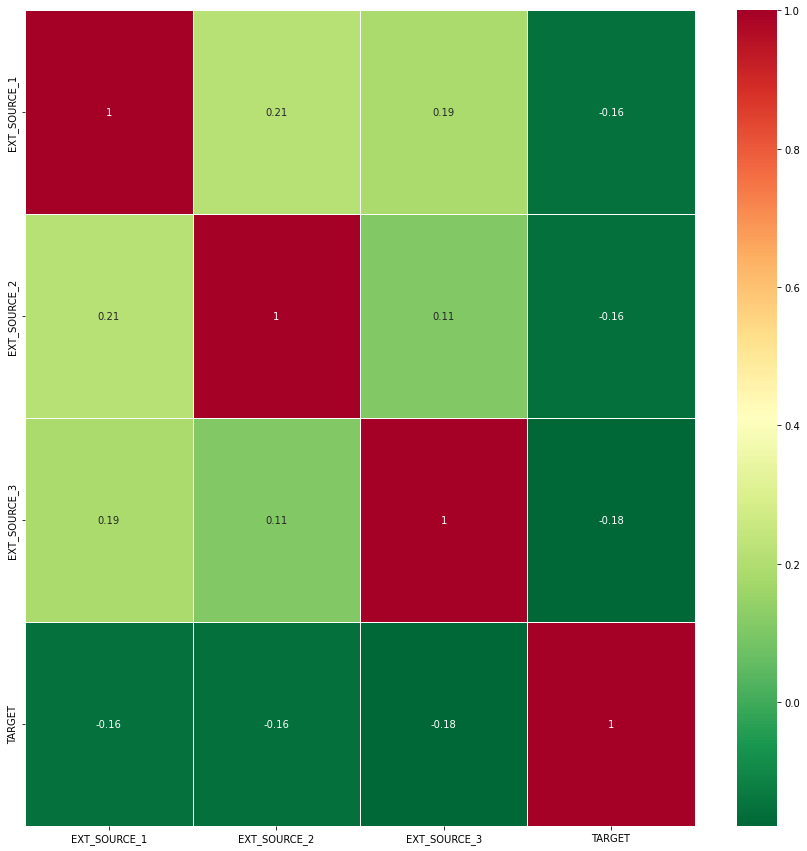

In [30]:
plt.figure(figsize=(15,15))
tmp = train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]]
sns.heatmap(tmp.corr(), cmap='RdYlGn_r', linewidths=1, annot=True)

In [43]:
c = train.corr().abs().dropna()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [76]:
for i in range(0, len(so) - train.shape[1], 10):
    print(so[i:i+10])

DAYS_LAST_DUE_1ST_VERSION    SK_ID_CURR_ccb                 3.877417e-07
SELLERPLACE_AREA             ENTRANCES_MEDI                 4.664618e-07
ENTRANCES_MEDI               SELLERPLACE_AREA               4.664618e-07
SK_DPD_DEF                   CNT_INSTALMENT_FUTURE          7.418265e-07
CNT_INSTALMENT_FUTURE        SK_DPD_DEF                     7.418265e-07
AMT_TOTAL_RECEIVABLE         YEARS_BEGINEXPLUATATION_AVG    9.793644e-07
YEARS_BEGINEXPLUATATION_AVG  AMT_TOTAL_RECEIVABLE           9.793644e-07
FLAG_EMAIL                   AMT_PAYMENT_CURRENT            1.088550e-06
AMT_PAYMENT_CURRENT          FLAG_EMAIL                     1.088550e-06
RATE_DOWN_PAYMENT            CNT_CHILDREN                   1.168471e-06
dtype: float64
YEARS_BEGINEXPLUATATION_AVG  CNT_INSTALMENT_FUTURE           0.000002
CNT_INSTALMENT_FUTURE        YEARS_BEGINEXPLUATATION_AVG     0.000002
COMMONAREA_MEDI              FLAG_OWN_REALTY                 0.000002
MONTHS_BALANCE_pcb           FLAG_DOCUMENT_14

CNT_INSTALMENT_FUTURE       AMT_GOODS_PRICE    0.001277
CNT_FAM_MEMBERS             AMT_CREDIT_pa      0.001277
AMT_CREDIT_pa               CNT_FAM_MEMBERS    0.001277
FLAG_DOCUMENT_9             SK_ID_PREV         0.001278
SK_ID_PREV                  FLAG_DOCUMENT_9    0.001278
DAYS_DECISION               TARGET             0.001279
TARGET                      DAYS_DECISION      0.001279
FLAG_DOCUMENT_6             AMT_APPLICATION    0.001279
AMT_APPLICATION             FLAG_DOCUMENT_6    0.001279
AMT_DRAWINGS_OTHER_CURRENT  SK_ID_PREV_pa      0.001279
dtype: float64
SK_ID_PREV_pa              AMT_DRAWINGS_OTHER_CURRENT    0.001279
FLOORSMIN_MEDI             DAYS_DECISION                 0.001279
AMT_REQ_CREDIT_BUREAU_QRT  REGION_POPULATION_RELATIVE    0.001279
AMT_INST_MIN_REGULARITY    REG_CITY_NOT_LIVE_CITY        0.001280
REG_CITY_NOT_LIVE_CITY     AMT_INST_MIN_REGULARITY       0.001280
AMT_APPLICATION            ENTRANCES_MEDI                0.001280
ENTRANCES_MEDI             AM

dtype: float64
ENTRANCES_AVG                AMT_DRAWINGS_OTHER_CURRENT     0.002055
AMT_DRAWINGS_OTHER_CURRENT   ENTRANCES_AVG                  0.002055
AMT_REQ_CREDIT_BUREAU_WEEK   ENTRANCES_MODE                 0.002057
YEARS_BEGINEXPLUATATION_AVG  SK_ID_CURR_ccb                 0.002057
SK_ID_CURR_ccb               YEARS_BEGINEXPLUATATION_AVG    0.002057
AMT_GOODS_PRICE              AMT_CREDIT_SUM                 0.002058
AMT_CREDIT_SUM               AMT_GOODS_PRICE                0.002058
MONTHS_BALANCE_pcb           AMT_CREDIT_SUM                 0.002058
AMT_CREDIT_SUM               MONTHS_BALANCE_pcb             0.002058
EXT_SOURCE_2                 AMT_RECEIVABLE_PRINCIPAL       0.002059
dtype: float64
FLAG_DOCUMENT_20        SK_DPD                     0.002060
AMT_CREDIT_SUM_OVERDUE  REG_CITY_NOT_WORK_CITY     0.002062
REG_CITY_NOT_WORK_CITY  AMT_CREDIT_SUM_OVERDUE     0.002062
FLOORSMIN_MEDI          AMT_RECIVABLE              0.002063
FLAG_CONT_MOBILE        AMT_INST_MIN_REG

NFLAG_INSURED_ON_APPROVAL   LANDAREA_AVG                  0.003816
HOUR_APPR_PROCESS_START_pa  SK_ID_BUREAU                  0.003817
SK_ID_BUREAU                HOUR_APPR_PROCESS_START_pa    0.003817
LIVINGAPARTMENTS_AVG        MONTHS_BALANCE_pcb            0.003819
AMT_DOWN_PAYMENT            ELEVATORS_AVG                 0.003819
NFLAG_INSURED_ON_APPROVAL   AMT_RECEIVABLE_PRINCIPAL      0.003825
FLAG_DOCUMENT_7             AMT_INCOME_TOTAL              0.003825
FLAG_DOCUMENT_21            TOTALAREA_MODE                0.003833
OWN_CAR_AGE                 AMT_INST_MIN_REGULARITY       0.003836
FLOORSMIN_MEDI              AMT_APPLICATION               0.003837
dtype: float64
ENTRANCES_AVG         SK_ID_BUREAU             0.003838
SK_ID_BUREAU          ENTRANCES_AVG            0.003838
RATE_DOWN_PAYMENT     BASEMENTAREA_AVG         0.003839
DAYS_ENDDATE_FACT     CNT_INSTALMENT_FUTURE    0.003842
AMT_CREDIT_SUM_LIMIT  FLAG_DOCUMENT_18         0.003842
DAYS_DECISION         LIVINGAREA_ME

FLAG_DOCUMENT_20         FLAG_DOCUMENT_16           0.082229
ELEVATORS_MEDI           AMT_GOODS_PRICE            0.082266
AMT_GOODS_PRICE          ELEVATORS_MEDI             0.082266
APARTMENTS_MEDI          HOUR_APPR_PROCESS_START    0.082531
HOUR_APPR_PROCESS_START  APARTMENTS_MEDI            0.082531
FLOORSMAX_MODE           FLAG_DOCUMENT_8            0.082669
FLAG_DOCUMENT_8          FLOORSMAX_MODE             0.082669
ELEVATORS_AVG            REG_CITY_NOT_WORK_CITY     0.082782
REG_CITY_NOT_WORK_CITY   ELEVATORS_AVG              0.082782
AMT_CREDIT               FLAG_DOCUMENT_8            0.082819
dtype: float64
FLAG_DOCUMENT_8          AMT_CREDIT                      0.082819
ENTRANCES_MEDI           FLOORSMAX_MEDI                  0.082909
FLOORSMAX_MEDI           ENTRANCES_MEDI                  0.082909
DAYS_LAST_PHONE_CHANGE   DAYS_BIRTH                      0.082939
LIVINGAPARTMENTS_AVG     YEARS_BEGINEXPLUATATION_MODE    0.083098
OWN_CAR_AGE              FLOORSMAX_MEDI      

In [78]:
c.TARGET.sort_values(kind="quicksort")

AMT_PAYMENT_TOTAL_CURRENT      0.000009
SK_DPD_DEF_pcb                 0.000121
AMT_PAYMENT_CURRENT            0.000240
FLAG_DOCUMENT_5                0.000316
CNT_INSTALMENT                 0.000382
                                 ...   
DAYS_ID_PUBLISH                0.051457
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, Length: 112, dtype: float64

Увы есть пропуски, попробуем вычислсить.

In [33]:
comp_mse(train[flags + ['EXT_SOURCE_1']].dropna(), flags, 'EXT_SOURCE_1')

Fold full 0: msle 0.01852409053243034, mse 0.03958162731112878
Fold full 1: msle 0.018583212282772123, mse 0.039568237927812146
Fold full 2: msle 0.018856334203429213, mse 0.040088659718983136
Fold full 3: msle 0.01854009114852447, mse 0.0394621552714603
Fold full 4: msle 0.0183916629485387, mse 0.03921873517622712
MSLE average = 0.018579078223138968, std = 0.0001526801181069193


In [35]:
def fillna_with_model(df, model, features, target):
    df[target] = np.where(df[target].isna(), model.predict(df[features]), df[target])

In [36]:
def fillna_EXT_SOURCE():
    model = SGDRegressor()
    target = 'EXT_SOURCE_1'
    part = train[flags + [target]].dropna()
    model.fit(X=part[flags], y=part[target])
    fillna_with_model(train, model, flags, target)
    fillna_with_model(test, model, flags, target)
    
    target = 'EXT_SOURCE_2'
    model = SGDRegressor()
    part =train[flags + [target]].dropna()
    model.fit(X=part[flags], y=part[target])
    fillna_with_model(train, model, flags, target) 
    fillna_with_model(test, model, flags, target)
    
    target = 'EXT_SOURCE_3'
    model = SGDRegressor()
    part = train[flags + [target]].dropna()
    model.fit(X=part[flags], y=part[target])
    fillna_with_model(train, model, flags, target)
    fillna_with_model(test, model, flags, target)

In [79]:
fillna_EXT_SOURCE()

In [80]:
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"])

Fold full 0: roc_auc 0.7278244445084507, count values [0.07178144 0.03418719 0.03755826 ... 0.05078456 0.07035047 0.07718528]
Fold full 1: roc_auc 0.7229565099470265, count values [0.42234102 0.09250149 0.10095724 ... 0.0796109  0.10072577 0.05164447]
Fold full 2: roc_auc 0.7221504056393147, count values [0.0698611  0.02669072 0.36089642 ... 0.04026334 0.03845178 0.08070522]
Fold full 3: roc_auc 0.7200809626148935, count values [0.04130889 0.02373769 0.07204318 ... 0.01864662 0.13551955 0.02746342]
Fold full 4: roc_auc 0.7180293014783502, count values [0.04618208 0.10800868 0.06152571 ... 0.07826911 0.06088133 0.08612832]
roc average = 0.7222083248376071, std = 0.0032891896270226925


## Private
0.49998
## Public
0.50072



Тут сказывается различие в количестве + и -, ниже попробуем их уровнять


In [87]:
train_1_plus = train[train[target] == 1]
train_1_minus = train[train[target] == 0]
train_1 = train_1_plus.append(train_1_minus.sample(train_1_plus.shape[0]))

In [88]:
train_1.shape

(49650, 208)

In [89]:
def predict_n_write_csv(train, features, path="predict1.csv"):
    target = "TARGET"
    
    model = LogisticRegression()
    train_part_x = train[features].fillna(0)
    train_part_y = train[target]
    model.fit(X=train_part_x, y = train_part_y)
    
    sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
    sample_submission[target] = model.predict(test[features]) 
    sample_submission.to_csv(path, index= False)

In [90]:
predict_n_write_csv(train_1, ['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3"], 'all_ext_souce.csv')

In [91]:
## Private
0.64493
## Public
0.66146



0.66146

Попробуем ещё вариант с EXT_SOURC

In [92]:
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_1'])
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_2'])
comp_roc(train[['EXT_SOURCE_1', 'EXT_SOURCE_2',"EXT_SOURCE_3", target]].dropna(), ['EXT_SOURCE_3'])

Fold full 0: roc_auc 0.6065737692301677, count values [0.12262468 0.07733663 0.06432056 ... 0.09847184 0.14196333 0.05598318]
Fold full 1: roc_auc 0.6104112557271641, count values [0.19782576 0.08617829 0.04079918 ... 0.07690093 0.08617829 0.08383314]
Fold full 2: roc_auc 0.6081932923243033, count values [0.08015529 0.08635292 0.08465996 ... 0.04951426 0.04951426 0.09869646]
Fold full 3: roc_auc 0.6066872018842123, count values [0.08965588 0.07733925 0.07733925 ... 0.14044984 0.17658051 0.04492209]
Fold full 4: roc_auc 0.6147460364741708, count values [0.07758319 0.05000372 0.09450153 ... 0.08009986 0.07758319 0.04461165]
roc average = 0.6093223111280037, std = 0.0030455069765370746
Fold full 0: roc_auc 0.6555066387072852, count values [0.05079782 0.11577373 0.06490677 ... 0.07444264 0.10932517 0.04684538]
Fold full 1: roc_auc 0.6605650633911433, count values [0.05483828 0.05087889 0.06618604 ... 0.06179885 0.06922595 0.18643772]
Fold full 2: roc_auc 0.6569392856625195, count values [0

In [93]:
def predict_by_one(df, feature, df2):
    model = LogisticRegression()
    
    model.fit(X=df[feature], y=df[target])
    predictation = feature[0] + '_predict'
    df[predictation] = model.predict(df[feature])
    df2[predictation] = model.predict(df2[feature])

In [94]:
predict_by_one(train_1, ['EXT_SOURCE_1'],test)
predict_by_one(train_1, ['EXT_SOURCE_2'],test)
predict_by_one(train_1, ['EXT_SOURCE_3'],test)

In [96]:
comp_roc(train_1[['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict", target]].dropna(), ['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict"])

Fold full 0: roc_auc 0.6763920889468753, count values [0.67670038 0.48223406 0.28632607 ... 0.47413508 0.47413508 0.48223406]
Fold full 1: roc_auc 0.6706703753789276, count values [0.58265741 0.76641452 0.59243103 ... 0.47493567 0.59243103 0.28608147]
Fold full 2: roc_auc 0.6799048108141199, count values [0.67337735 0.48164812 0.58245854 ... 0.47210855 0.47210855 0.28728178]
Fold full 3: roc_auc 0.6792689706277959, count values [0.47416921 0.76458678 0.67614273 ... 0.38690795 0.47416921 0.47416921]
Fold full 4: roc_auc 0.6768308385055374, count values [0.76526081 0.58527752 0.2870108  ... 0.2870108  0.48183766 0.2870108 ]
roc average = 0.6766134168546512, std = 0.0032650035294834114


### Private
0.62106

### Public
0.63881


In [97]:
predict_n_write_csv(train_1, ['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict"], 'all_ext_souce_plus.csv')

Раз мы можем получить из флагов EXT_SOURCE, значит из них можем получить и финальный результат:

In [98]:
comp_roc(train_1[flags + [target]].dropna(), flags)

Fold full 0: roc_auc 0.5658159025722873, count values [0.51943599 0.51943599 0.51943599 ... 0.60575509 0.46059629 0.51943599]
Fold full 1: roc_auc 0.5612911026714708, count values [0.51944147 0.52002539 0.52002539 ... 0.65710959 0.51944147 0.39433488]
Fold full 2: roc_auc 0.5725688890316912, count values [0.54944642 0.61983734 0.51745743 ... 0.39427128 0.5089591  0.402424  ]
Fold full 3: roc_auc 0.5870390003190415, count values [0.51745314 0.51079684 0.4069261  ... 0.51079684 0.51745314 0.45794181]
Fold full 4: roc_auc 0.5712735672951278, count values [0.39729589 0.51895353 0.45878387 ... 0.45878387 0.5097912  0.51895353]
roc average = 0.5715976923779238, std = 0.008707894759076254


### Private
0.55456

### Public
0.55075

такое себе - стало хуже

In [99]:
predict_n_write_csv(train_1, flags, 'just_flags.csv')

Попробую добваить новый флаг

In [100]:
train_1["have_big_credit"] = train_1['AMT_CREDIT_SUM'] > train_1['AMT_GOODS_PRICE']
train_1["have_big_credit"] = np.where(train_1["have_big_credit"], 1, 0)

In [101]:
comp_roc(train_1[['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict"] + [target, 'have_big_credit']].dropna(), ['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict", 'have_big_credit'])

Fold full 0: roc_auc 0.6767152968987452, count values [0.47225223 0.67577546 0.28850785 ... 0.28441751 0.59678982 0.28441751]
Fold full 1: roc_auc 0.6701761703566298, count values [0.58477467 0.767647   0.58477467 ... 0.28515704 0.47396386 0.47396386]
Fold full 2: roc_auc 0.6791611007744542, count values [0.28872137 0.46501751 0.67611502 ... 0.47311123 0.28872137 0.4773983 ]
Fold full 3: roc_auc 0.6784526862002094, count values [0.4846978  0.76527942 0.59454248 ... 0.28850327 0.46380596 0.4846978 ]
Fold full 4: roc_auc 0.6796923635403844, count values [0.76622441 0.67551353 0.67551353 ... 0.59374293 0.28854779 0.47631913]
roc average = 0.6768395235540847, std = 0.003479839611141602


### Private
0.62106

### Public
0.63881

стало лучше

In [104]:
test=test.join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b')
# train=train.join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b')


In [105]:
train_1["have_big_credit"] = train_1['AMT_CREDIT_SUM'] > train_1['AMT_GOODS_PRICE']
train_1["have_big_credit"] = np.where(train_1["have_big_credit"], 1, 0)

test["have_big_credit"] = test['AMT_CREDIT_SUM'] > test['AMT_GOODS_PRICE']
test["have_big_credit"] = np.where(test["have_big_credit"], 1, 0)

In [106]:
flags.append('have_big_credit')

In [108]:
predict_n_write_csv(train_1, ['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict", 'have_big_credit'], 'just_flags_plus.csv')

In [109]:
def count_docs(df):
    df['DOCUMENT_FLAGS_COUNT'] = df['FLAG_DOCUMENT_2'] + df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_4'] + df['FLAG_DOCUMENT_5'] + df['FLAG_DOCUMENT_6'] + df['FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] + df['FLAG_DOCUMENT_10'] + df['FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_12'] + df['FLAG_DOCUMENT_13'] + df['FLAG_DOCUMENT_14'] + df['FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] + df['FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_20'] + df['FLAG_DOCUMENT_21']

In [110]:
count_docs(train_1)
count_docs(test)

In [74]:
comp_roc(lite[['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict", "DOCUMENT_FLAGS_COUNT", target]], ['EXT_SOURCE_1_predict', 'EXT_SOURCE_2_predict',"EXT_SOURCE_3_predict", "DOCUMENT_FLAGS_COUNT"])

Fold full 0: roc_auc 0.6834854006556528, count values [0.57231214 0.57231214 0.72809982 ... 0.2545449  0.3436628  0.28925956]
Fold full 1: roc_auc 0.6760622405858367, count values [0.57240697 0.68294327 0.71775335 ... 0.38131817 0.38131817 0.28944933]
Fold full 2: roc_auc 0.6756963892548024, count values [0.76683531 0.28866229 0.76683531 ... 0.76683531 0.60056205 0.33605697]
Fold full 3: roc_auc 0.6839099694742815, count values [0.38430017 0.57510512 0.76221219 ... 0.44158822 0.38430017 0.292343  ]
Fold full 4: roc_auc 0.6748105579028507, count values [0.67725561 0.57687875 0.60784681 ... 0.73122265 0.49610764 0.52891265]
roc average = 0.6787929115746849, std = 0.004027602031414368


### Private
0.62106

### Public
0.63881

ничего не поменялось опять